# Interpreting Object Detection Models using Grad-CAM

This jupyter notebook gives a tutorial of using Grad-CAM for object detection tasks. We consider two kinds of models, [Mask-RCNN (with BBox Branch only)](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.4/configs/mask_rcnn) and [PP-YOLOE](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.4/configs/ppyoloe). Both of them link to PaddleDetection pages. Moreover, this tutorial is based on PaddleDetection. 

All steps following require [PaddleDetection/release2.4](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.4) to run. For extending this tutorial to your own tasks, some modifications have to be made. We are working on providing off-the-shelf methods, where no modifications on the source code of models are required. 

Currently, we have to do some modifications on PaddleDetection's source codes to make things easy.

## Mask-RCNN 

First let's interpret Mask-RCNN (BBox head only). 

1. Get the source code and install requirements

```bash

wget -c https://github.com/PaddlePaddle/PaddleDetection/archive/refs/tags/v2.4.0.zip
unzip v2.4.0.zip
cd PaddleDetection-release-2.4

pip install -r requirements.txt # -i https://pypi.tuna.tsinghua.edu.cn/simple  # with tsinghua mirror.

```

2. Modify the code ppdet/modeling/heads/bbox_head.py by adding the follow lines between `pred = self.get_prediction(scores, deltas)` (line256) and `return pred, self.head` (line257):

```python
    np.save("roi.npy", {"rois_feat": rois_feat.numpy(), 
                      "rois": rois[0].numpy() })

    for bbox_i in range(100):
        predicted_label = paddle.argmax(pred[1][bbox_i])

        grad = paddle.grad(outputs=pred[1][bbox_i, predicted_label], inputs=rois_feat, retain_graph=True)[0]
        np.save(f"grad_{bbox_i}.npy", {
                          "grad": grad.numpy()[bbox_i],
                          "proba": pred[1][bbox_i, predicted_label].numpy(),
                          "label": predicted_label.numpy()
                         })
        print("saving grad w.r.t.", f"grad_{bbox_i}")

```

Note that `range(100)` is just a showing case, readers can modify this to any indexes they want. There are 1000 bounding boxes proposed by rpn_head. They will be processed by the post_process (nms). However, nms is not a differentiable process, and thus no gradients. So here we choose to compute gradients through raw bbox predictions. For further implementations, a mapping between these 1000 boxes and the final boxes can be easily obtained via finding the nearest box.

3. Run the script provided by PaddleDetection

```bash

python tools/infer.py -c configs/mask_rcnn/mask_rcnn_r50_vd_fpn_2x_coco.yml --infer_img demo/000000014439.jpg -o weights=https://paddledet.bj.bcebos.com/models/mask_rcnn_r50_vd_fpn_2x_coco.pdparams

```

After this script, a list of `.npy` files will be saved, including 100 `grad_i.npy` and `roi.npy`.

Let's see the explanation results.

### Image 

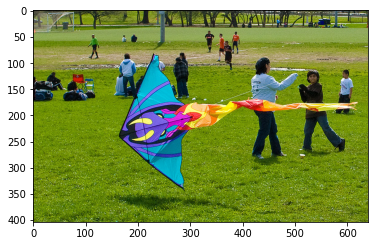

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open("../PaddleDetection-release-2.4/demo/000000014439.jpg")
img = np.array(img)

plt.imshow(img)
plt.show()

### Load ROI features

In [5]:
import numpy as np
rois = np.load('../PaddleDetection-release-2.4/roi.npy', allow_pickle=True).item()

rois['rois_feat'].shape, rois['rois'].shape

((1000, 256, 7, 7), (1000, 4))

### heatmap function

In [6]:
def _heatmap(explanation, resize_shape) -> np.ndarray:
    """

    Args:
        explanation:
        resize_shape: (width, height)

    Returns:

    """
    assert len(explanation.shape) == 2, f"{explanation.shape}. " \
                                        f"Currently support 2D explanation results for visualization. " \
                                        "Reduce higher dimensions to 2D for visualization."
    
    explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min()) 

    explanation = cv2.resize(explanation, resize_shape)
    explanation = np.uint8(255 * explanation)
    explanation = cv2.applyColorMap(explanation, cv2.COLORMAP_JET)
    explanation = cv2.cvtColor(explanation, cv2.COLOR_BGR2RGB)

    return explanation

### Explanation results

Here only four bounding boxes are shown, which correspond to four large instances. Other instances are smaller but show similar results. Readers are encouraged to try other cases.

Bounding Box index of  1
predicted class: [0]
proba: [0.9939752]
(404, 640, 3) (197, 70, 3) 413 483 87 284


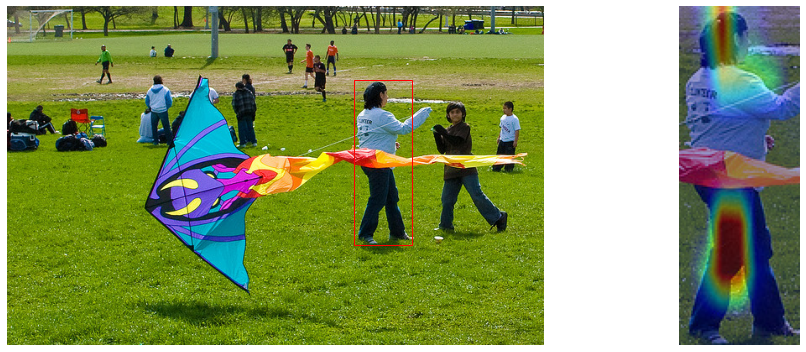

Bounding Box index of  11
predicted class: [0]
proba: [0.9971238]
(404, 640, 3) (166, 79, 3) 507 586 107 273


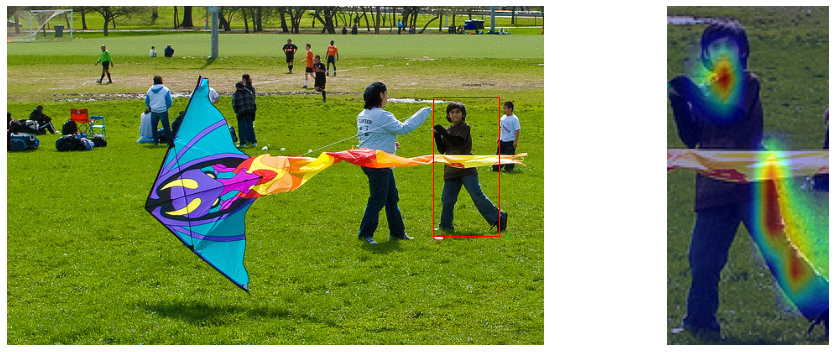

Bounding Box index of  13
predicted class: [56]
proba: [0.9515247]
(404, 640, 3) (37, 41, 3) 74 115 119 156


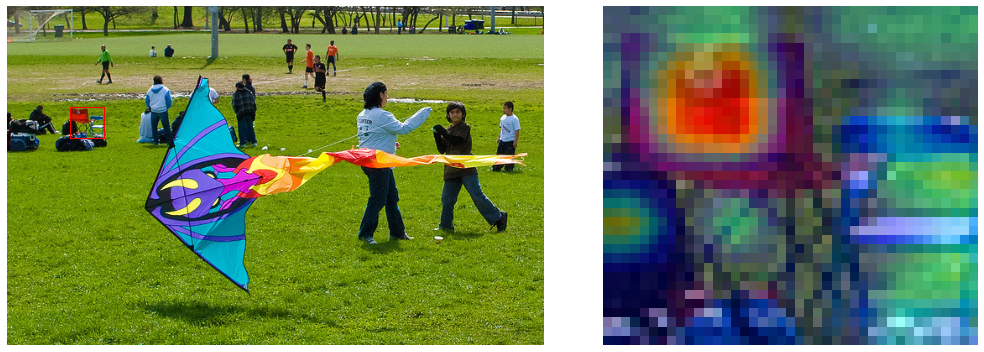

Bounding Box index of  15
predicted class: [33]
proba: [0.6455254]
(404, 640, 3) (218, 241, 3) 143 384 131 349


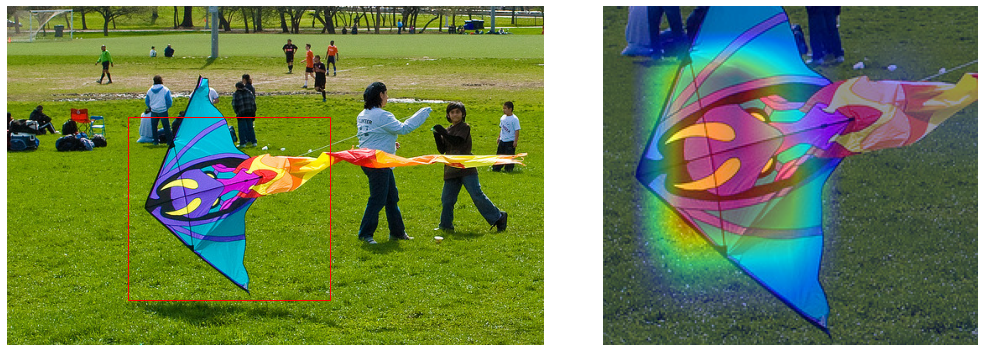

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import cv2

for bbox_i in [1, 11, 13, 15]: # range(100):
    print("Bounding Box index of ", bbox_i)
    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for ax in axes:
        ax.axis("off")

    ## axes[0]
    # Display the image
    axes[0].imshow(img)

    tl_x = rois['rois'][bbox_i, 0]
    tl_y = rois['rois'][bbox_i, 1]
    width = rois['rois'][bbox_i, 2] - tl_x
    height = rois['rois'][bbox_i, 3] - tl_y
    scaler = 0.5

    # Create a Rectangle patch
    rect = patches.Rectangle( (tl_x*scaler, tl_y*scaler), width*scaler, height*scaler, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    axes[0].add_patch(rect)

    ## axes[1]
    bb_img = copy.deepcopy(img[int(tl_y*scaler):int(tl_y*scaler+height*scaler), int(tl_x*scaler):int(tl_x*scaler+width*scaler)])

    # load computed gradients.
    grad = np.load(f'../PaddleDetection-release-2.4/grad_{bbox_i}.npy', allow_pickle=True).item()
    print('predicted class:', grad['label'])
    print('proba:', grad['proba'])

    # grad-cam
    b = (rois['rois_feat'][bbox_i] * grad['grad'].mean((1,2), keepdims=True)).mean(axis=0)
    exp = np.maximum(-b, 0)
    # exp = np.abs(b)

    print(img.shape, bb_img.shape, int(tl_x*scaler), int(tl_x*scaler+width*scaler), int(tl_y*scaler), int(tl_y*scaler+height*scaler))

    resized_exp = _heatmap(exp, (bb_img.shape[1], bb_img.shape[0]))
    overlay_vis = np.uint8(resized_exp * 0.4 + bb_img * 0.6)
    axes[1].imshow(overlay_vis)

    fig.tight_layout()
    plt.show()

## PPYOLOE

Now let's see the Grad-CAM explanations for [PPYOLOE](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.4/configs/ppyoloe).

### Though this part of tutorial uses the model of PPYOLOE, it is applicable for other YOLOV3 based models.

For the same reason that `nms` stop gradients, we need to get gradients before the last post process step. For PPYOLOE, which uses YOLOV3 as the architecture, we modify the source codes YOLOV3 from PaddleDetection. This is very similar to the modification for Mask-RCNN.

For the completeness, we repeat all the steps that are needed to show the visaulization.

1. (The same as for Mask-RCNN) Get the source code and install requirements

```bash
wget -c https://github.com/PaddlePaddle/PaddleDetection/archive/refs/tags/v2.4.0.zip
unzip v2.4.0.zip
cd PaddleDetection-release-2.4

pip install -r requirements.txt # -i https://pypi.tuna.tsinghua.edu.cn/simple  # with tsinghua mirror.

```

2. Modify the code ppdet/modeling/architectures/yolo.py by adding the follow lines between `yolo_head_outs = self.yolo_head(neck_feats)` (line96) and `if self.for_mot:` (line98):

```python
    import numpy as np
    import paddle
    np.save('ppyoloe_r.npy', {
        'body_feats': [b.numpy() for b in body_feats],
        'pred_scores': yolo_head_outs[0].numpy(),
        'pred_dist': yolo_head_outs[1].numpy(),
        'anchor_points': yolo_head_outs[2].numpy(),
        'stride_tensor': yolo_head_outs[3].numpy()
    })

    pred_scores = yolo_head_outs[0]
    pred_scores_np = pred_scores.numpy()
    for bbox_i in range(pred_scores_np.shape[-1]):
        if max(pred_scores_np[0, :, bbox_i]) < 0.75:
            # there are many bbox that are not confident.
            continue
        predicted_label = paddle.argmax(pred_scores[0, :, bbox_i])
        grad = paddle.grad(outputs=pred_scores[0, predicted_label, bbox_i], inputs=body_feats, retain_graph=True)
        # print("-- grad", grad)
        np.save(f"ppyoloe_grad_{bbox_i}.npy", {
                          "grad": [g.numpy() for g in grad],
                          "proba": pred_scores[0, predicted_label, bbox_i].numpy(),
                          "label": predicted_label.numpy()
                         })
```

Note that `pred_scores_np.shape[-1]=8400`, which is the sum of `20x20+40x40+80x80`. Since PPYOLOE uses a CustomizedPAN as neck, we consider a layer from the backbone. But using the layer after the neck may work too. 


3. Run the script provided by PaddleDetection

```bash
python tools/infer.py -c configs/ppyoloe/ppyoloe_crn_l_300e_coco.yml --infer_img demo/000000014439.jpg -o weights=https://paddledet.bj.bcebos.com/models/ppyoloe_crn_l_300e_coco.pdparams
```

In [18]:
# the same function as for Mask-RCNN, just for visualization.

def _heatmap(explanation, resize_shape) -> np.ndarray:
    """

    Args:
        explanation:
        resize_shape: (width, height)

    Returns:

    """
    assert len(explanation.shape) == 2, f"{explanation.shape}. " \
                                        f"Currently support 2D explanation results for visualization. " \
                                        "Reduce higher dimensions to 2D for visualization."
    
    explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min()) 

    explanation = cv2.resize(explanation, resize_shape)
    explanation = np.uint8(255 * explanation)
    explanation = cv2.applyColorMap(explanation, cv2.COLORMAP_JET)
    explanation = cv2.cvtColor(explanation, cv2.COLOR_BGR2RGB)

    return explanation

In [19]:
from PIL import Image
import numpy as np

img = Image.open("../PaddleDetection-release-2.4/demo/000000014439_640x640.jpg")
img = np.array(img)

feats = np.load('../PaddleDetection-release-2.4/ppyoloe_r.npy', allow_pickle=True).item()

Bounding Box index of  153
[414.56998] [141.37015] [91.47629] [309.1002] [32.] 0.7688193 0
predicted class: [0]
proba: [0.7688193]
(20, 20) 141 450 414 506


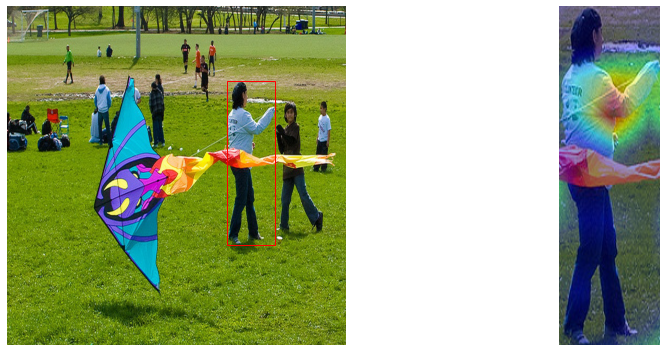

Bounding Box index of  210
[162.66432] [131.62247] [463.3745] [413.92136] [32.] 0.9638822 33
predicted class: [33]
proba: [0.9638822]
(20, 20) 131 545 162 626


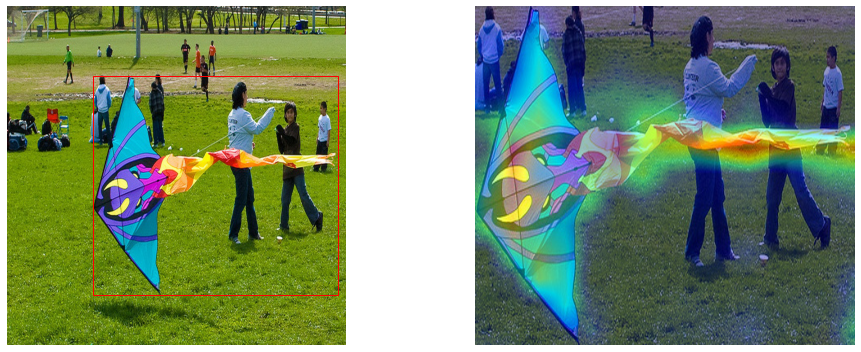

Bounding Box index of  997
[581.18274] [179.11401] [31.4245] [134.91699] [16.] 0.81386113 0
predicted class: [0]
proba: [0.81386113]
(20, 20) 179 314 581 612


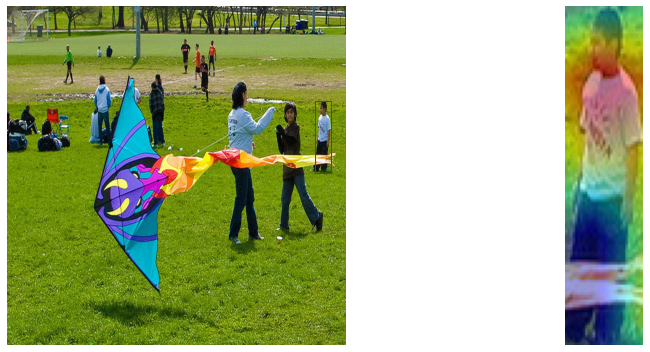

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import cv2

for bbox_i in [153, 210, 997]: 
    if max(feats['pred_scores'][0, :, bbox_i]) < 0.75:
        continue
        
    print("Bounding Box index of ", bbox_i)
    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for ax in axes:
        ax.axis("off")

    ltx, lty, rbx, rby = feats['pred_dist'][0, :, bbox_i]

    x1 = -ltx + feats['anchor_points'][bbox_i][0]
    y1 = -lty + feats['anchor_points'][bbox_i][1]

    x2 = rbx + feats['anchor_points'][bbox_i][0]
    y2 = rby + feats['anchor_points'][bbox_i][1]

    ## axes[0]
    # Display the image
    axes[0].imshow(img)

    scaler = feats['stride_tensor'][bbox_i]
    tl_x = x1 * scaler
    tl_y = y1 * scaler
    width = x2 * scaler - tl_x
    height = y2 * scaler - tl_y

    print(tl_x, tl_y, width, height, scaler, max(feats['pred_scores'][0, :, bbox_i]), np.argmax(feats['pred_scores'][0, :, bbox_i]))

    # Create a Rectangle patch
    rect = patches.Rectangle( (tl_x, tl_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    axes[0].add_patch(rect)

    ## axes[1]
    bb_img = copy.deepcopy(img[int(tl_y):int(tl_y+height), int(tl_x):int(tl_x+width)])

    # load computed gradients.
    grad = np.load(f"../PaddleDetection-release-2.4/ppyoloe_grad_{bbox_i}.npy", allow_pickle=True).item()
    print('predicted class:', grad['label'])
    print('proba:', grad['proba'])

    # grad-cam 
    stride = 2
    b = (feats['body_feats'][stride] * grad['grad'][stride].mean((2,3), keepdims=True)).mean(axis=1)
    exp = np.maximum(-b, 0)[0]
    resized_exp = cv2.resize(exp, (640, 640))
    print(exp.shape, int(tl_y), int(tl_y+height), int(tl_x), int(tl_x+width))
    resized_exp = _heatmap(resized_exp[int(tl_y):int(tl_y+height), int(tl_x):int(tl_x+width)], (bb_img.shape[1], bb_img.shape[0]))
    overlay_vis = np.uint8(resized_exp * 0.4 + bb_img * 0.6)

    axes[1].imshow(overlay_vis)

    fig.tight_layout()
    plt.show()

We can see that the two models (Mask-RCNN and PPYOLOE) do not give the same explanations for similar bounding box pedictions. 

For more details and other applications, please contact us directly.